In [1]:
import simpy
import random
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt 
from statistics import mean
import seaborn as sns


#---------------------------------------------------------

# Global class for variables

class g:
    MEAN_RECEPTION_TIME = 5       # Minutes to process by the receptionist
    MEAN_RADIOGRAPHER_TIME = 5   # Minutes to process by the radiographer
    MEAN_CT_TIME = 15             # Minutes for the Scheduled CT scan
    
    # For scheduled patients 
    INTER_ARRIVAL_TIME = 10       # Minutes between scheduled patients

    # Emergency variables
    STD_DEV_EMERG = 5
    EMERGENCY_INTER_ARRIVAL_TIME = 15 # Minutes between emergency patients
    MEAN_EMERG_TIME = 15          # Minutes for Emergency CT

    
    # Simulation variables
    SIMULATION_TIME = 600         # Simulate a 10 hour day
    NUMBER_OF_SIMS = 100          # How many times to run the simulation
    

    
    # Capacity for resources
    RECEPTION_CAPACITY = 1
    RADIOGRAPHER_CAPACITY = 1
    CT_CAPACITY = 2
      
    #decontamination variables
    decon_mean = 20
    decon_std_dev = 5 
    percent_infect = 0.2

    
    
    
# ------------------------------------------------  
# Classes for patients - emergency and scheduled
    
    
class CT_patient:
    PRIORITY = 2

    def __init__(self, p_id):
        self.id = p_id
        
        
        # to record the times
        self.q_time_reg = 0
        self.q_time_radiographer = 0
        self.q_time_CT = 0

        
class emergency_patient:
    PRIORITY = 1

    def __init__(self, p_id):
        self.id = p_id

        
        
#-------------------------------------------------------------------------
# model/pathway of emergency patients 
        
class emergency_CT_model:

    def __init__(self, env, radiographer, ct):
        self.env = env
        self.radiographer = radiographer
        self.ct = ct
    
    def process(self, patient):
             
        # Radiographer process
        with self.radiographer.request(priority=patient.PRIORITY) as req:
            yield req
            yield self.env.timeout(random.expovariate(1/g.MEAN_RADIOGRAPHER_TIME))
        
        # Emergency CT Scan
        start_q_CT_scan = self.env.now
        with self.ct.request(priority=patient.PRIORITY) as req:
            yield req
            # record time patient stops q'ing for CT
            end_q_CT_scan = self.env.now
            
            # calculate the Q time taken
            patient.q_time_CT = (end_q_CT_scan - start_q_CT_scan)            

            # if decontamination after is required
            if random.random() > g.percent_infect:
                sampled_CT_time = max(random.gauss(g.MEAN_EMERG_TIME, g.STD_DEV_EMERG), 5)
                # stop the patients journey by this time
                yield self.env.timeout( sampled_CT_time )
           
            else:
                # decontamination is required
                sampled_CT_time = max(random.gauss(g.decon_mean, g.decon_std_dev), 5)
                # stop the patient journey by this time
                yield self.env.timeout(sampled_CT_time)

                
                
# --------------------------------------------------------------------------
# radiology dept model                
                
class Radiology_dept_model:

    def __init__(self, env, reception, radiographer, ct):
        self.env = env
        self.reception = reception
        self.radiographer = radiographer
        self.ct = ct
        
        # setting up the variables to capture the data
        self.mean_q_time_registration = 0
        self.mean_q_time_radiographer = 0
        self.mean_q_time_CT_scanner = 0
        
        
        # setting the patient counter to track 
        self.patient_counter = 0

        # setting up the results df
        self.results_df = pd.DataFrame()
        self.results_df["P_ID"] = []
        self.results_df["mean_q_time_registration"] = []
        self.results_df["mean_q_time_radiographer"] = []
        self.results_df["mean_q_time_ct_scan"] = []
        self.results_df.set_index("P_ID", inplace=True)
        
    
    def process(self, patient):
        # Reception process
        time_checked_in_at_reception = env.now
        with self.reception.request(priority=patient.PRIORITY) as req:
            yield req          
            time_finished_reception = self.env.now
            patient.q_time_reg = (time_finished_reception - time_checked_in_at_reception)
            yield self.env.timeout(random.expovariate(1/g.MEAN_RECEPTION_TIME))
        
        
        
        
        # Radiographer process
        time_checked_in_at_radiographer = self.env.now

        with self.radiographer.request(priority=patient.PRIORITY) as req:
            yield req
            time_finished_radiographer = self.env.now            
            patient.q_time_radiographer = (time_finished_radiographer - time_checked_in_at_radiographer)         
            yield self.env.timeout(random.expovariate(1/g.MEAN_RADIOGRAPHER_TIME))
        
        
               
        # CT Scan
        start_q_CT_scan = self.env.now
        with self.ct.request(priority=patient.PRIORITY) as req:
            yield req
            # record time patient stops q'ing for CT
            end_q_CT_scan = self.env.now
            
            # calculate the Q time taken
            patient.q_time_CT = (end_q_CT_scan - start_q_CT_scan)            

            # if decontamination after is required
            if random.random() > g.percent_infect:
                sampled_CT_time = max(random.expovariate(1.0 / g.MEAN_CT_TIME), 3)
                # stop the patients journey by this time
                yield self.env.timeout( sampled_CT_time )
           
            else:
                # decontamination is required
                sampled_CT_time = max(random.gauss(g.decon_mean, g.decon_std_dev), 5)
                # stop the patient journey by this time
                yield self.env.timeout(sampled_CT_time)
                
        # finally storing the patient results        
        self.store_patient_results(patient)
        
        
    # A method to store the queuing times with the patient ID in a Pandas DataFrame
    def store_patient_results(self, patient):        
        df_to_add = pd.DataFrame({"P_ID":[patient.id],
                                  "q_time_registration":[patient.q_time_reg],
                                  "q_time_radiographer":[patient.q_time_radiographer],
                                  "q_time_ct_scan":(
                                      [patient.q_time_CT])
                                  })
        
        df_to_add.set_index("P_ID", inplace=True)
        self.results_df = self.results_df.append(df_to_add)
          

        # writing the results to a file
        with open("CT_single_run.csv", "a") as f:
            writer = csv.writer(f, delimiter=",")
            results_to_write = [patient.id,
                                patient.q_time_reg,
                                patient.q_time_radiographer,
                                patient.q_time_CT
                               ]
            writer.writerow(results_to_write)  


            
            
    def calculate_mean_q_times(self):
        self.mean_q_time_registration = self.results_df["q_time_registration"].mean()       
        self.mean_q_time_radiographer = self.results_df["q_time_radiographer"].mean()       
        self.mean_q_time_CT_scanner   = self.results_df["q_time_ct_scan"].mean()                 

            
            
    # writing the results to a file
    def write_run_results(self, run_number):
        with open("trial_CT_scan_sim.csv", "a") as f:
            writer = csv.writer(f, delimiter=",")
            results_to_write = [run_number,
                                self.mean_q_time_registration,
                                self.mean_q_time_radiographer,
                                self.mean_q_time_CT_scanner
                               ]
            writer.writerow(results_to_write)        

            
# ------------------------
# adding the simpy environment to all the pieces
            
            
            
def setup_simulation(env, run_number):
    reception = simpy.PriorityResource(env, capacity=g.RECEPTION_CAPACITY)
    radiographer = simpy.PriorityResource(env, capacity=g.RADIOGRAPHER_CAPACITY)
    ct = simpy.PriorityResource(env, capacity=g.CT_CAPACITY)

    radiology_model = Radiology_dept_model(env, reception, radiographer, ct)
    emergency_model = emergency_CT_model(env, radiographer, ct)
    
    # Start generating scheduled patients
    env.process(generate_scheduled_patients(env, radiology_model))
    # Start generating emergency patients
    env.process(generate_emergency_patients(env, emergency_model))
    
    
    env.run(until=g.SIMULATION_TIME)

    radiology_model.calculate_mean_q_times()
    radiology_model.write_run_results(run_number)

    

def generate_scheduled_patients(env, radiology_model):
    count = 0
    while True:
        count += 1
        patient = CT_patient(f"Scheduled-{count}")
        env.process(radiology_model.process(patient))
        scheduled_patient = env.now
        yield env.timeout(g.INTER_ARRIVAL_TIME)

def generate_emergency_patients(env, emergency_model):
    count = 0
    while True:
        count += 1
        patient = emergency_patient(f"Emergency-{count}")
        emerg_patient = env.now

        env.process(emergency_model.process(patient))
        yield env.timeout(random.expovariate(1/g.EMERGENCY_INTER_ARRIVAL_TIME))

        
#------------------------------------------------------------        
#class for creating results    
    
# Class for writing trial results 
class Multiple_Run_Results_Calculator:
    def __init__(self):
        self.trial_results_df = pd.DataFrame()
        
    # A method to read in the trial results and print them for the user
    def record_sim_results(self, run_number):
        # Read in results from each run
        self.trial_results_df = pd.read_csv("trial_CT_scan_sim.csv")
        
        # Take average over runs
        multiple_mean_q_time_registration = (
            self.trial_results_df["mean_q_time_registration"].mean())
        multiple_mean_q_time_radiographer = (
            self.trial_results_df["mean_q_time_radiographer"].mean())
        multiple_mean_q_time_CT = (
            self.trial_results_df["mean_q_time_ct_scan"].mean())
        
        
        # writing the results to a file
        with open("CT_simulation_run.csv", "a") as f:
            writer = csv.writer(f, delimiter=",")
            results_to_write = [run_number,
                                multiple_mean_q_time_registration,
                                multiple_mean_q_time_radiographer,
                                multiple_mean_q_time_CT
                               ]
            writer.writerow(results_to_write)    
        
        
        
#------------------------------------------------------------------
# running the program 
        
if __name__ == "__main__":
  
    
    # creating a file to store the results
    with open("trial_CT_scan_sim.csv", "w") as f:
        writer = csv.writer(f, delimiter=",")
        column_headers = ["Run",
                          "mean_q_time_registration",
                          "mean_q_time_radiographer",
                          "mean_q_time_ct_scan"]
        writer.writerow(column_headers)

        
    with open("CT_simulation_run.csv", "w") as f:
        writer = csv.writer(f, delimiter=",")
        column_headers = ["Run",
                          "multiple_mean_q_time_registration",
                          "multiple_mean_q_time_radiographer",
                          "multiple_mean_q_time_CT"]
        writer.writerow(column_headers)        

    

    for run in range(g.NUMBER_OF_SIMS):
        
        with open("CT_single_run.csv", "w") as f:
            writer = csv.writer(f, delimiter=",")
            column_headers = ["P_ID",
                              "q_time_registration",
                              "q_time_radiographer",
                              "q_time_CT"]
            writer.writerow(column_headers)
                
        run_number = run+1
        env = simpy.Environment()
        setup_simulation(env, run_number)

        
    multiple_run_results = Multiple_Run_Results_Calculator()
    multiple_run_results.record_sim_results(run)
        
    print("Simulation done!")

Simulation done!


# Analysing the Data Created

## Creating the visuals 

In [2]:
# reading in the files

single_run = pd.read_csv(r'C:\Users\Jack Dunne\CT_single_run.csv')
multiple_runs = pd.read_csv(r'C:\Users\Jack Dunne\trial_CT_scan_sim.csv')
mean_multiple = pd.read_csv(r'C:\Users\Jack Dunne\CT_simulation_run.csv')

single_run.columns
single_run = single_run.set_index('P_ID')

multiple_runs = multiple_runs.set_index('Run')
multiple_runs['Total wait time']= multiple_runs.sum(axis=1)

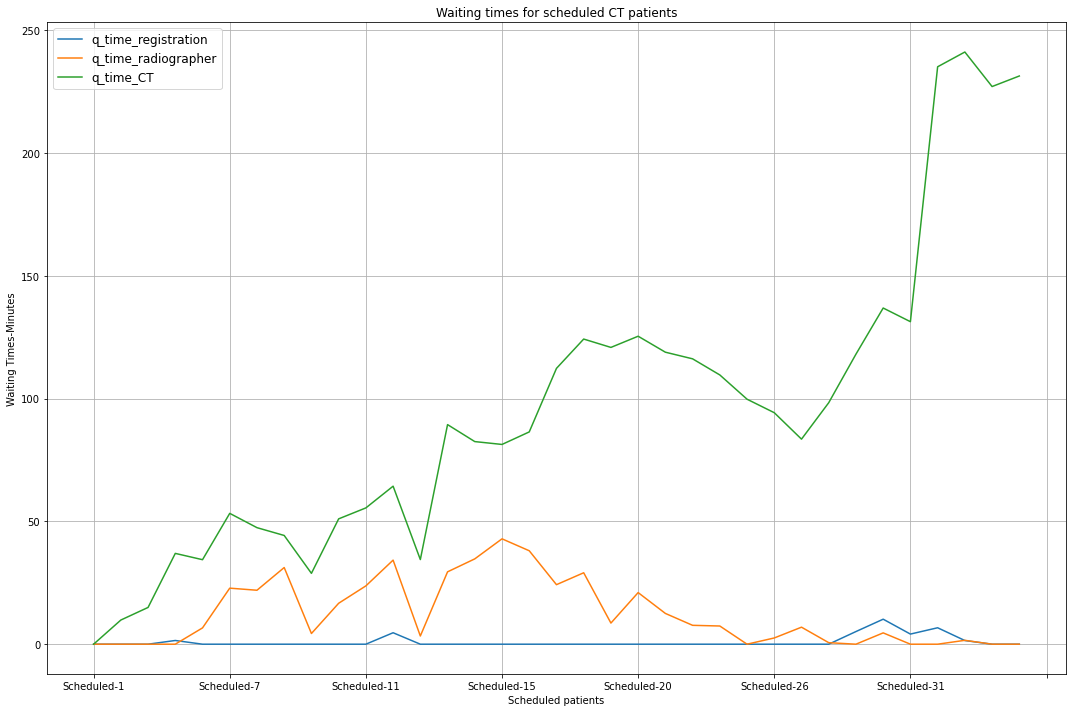

In [3]:
# Create the plot

ax = single_run.plot(figsize=(15, 10))

ax.set_xlabel("Scheduled patients")

ax.set_ylabel("Waiting Times-Minutes")

plt.title('Waiting times for scheduled CT patients')

plt.legend(loc='upper left', fontsize=12)

plt.tight_layout()

plt.style.use('bmh')

plt.grid(True)

plt.show()

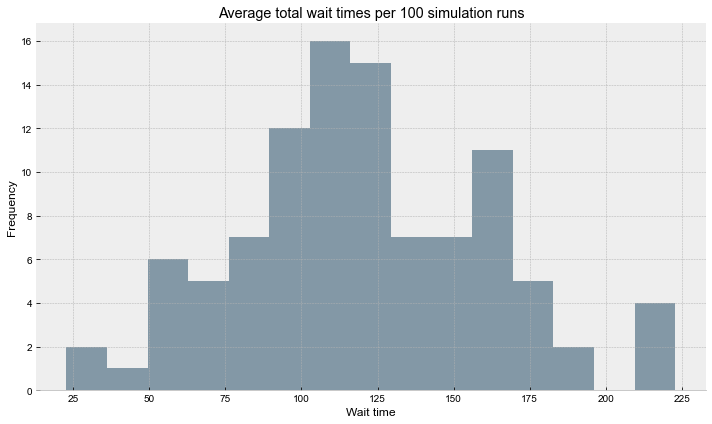

In [4]:
# 2. Plotting with Matplotlib
plt.figure(figsize=(10, 6))
plt.hist(multiple_runs['Total wait time'], bins=15, alpha=0.75, color='#607c8e')

# 3. Enhancing the Plot with Seaborn
sns.set_style("whitegrid")
sns.despine(left=True)
plt.title("Average total wait times per 100 simulation runs")
plt.xlabel("Wait time")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

## creating the statistics 

In [5]:
print('Median ', multiple_runs['Total wait time'].median(), sep='')
print('Mean ', multiple_runs['Total wait time'].mean())
print('Max ', multiple_runs['Total wait time'].max())
print('Min ', multiple_runs['Total wait time'].min())

Median 116.20204092571564
Mean  120.05138782764118
Max  222.72503925301754
Min  22.855632098865627


In [6]:
print('Radiographer ', multiple_runs['mean_q_time_radiographer'].mean())
print('Registration ', multiple_runs['mean_q_time_registration'].mean())
print('CT Scanner ', multiple_runs['mean_q_time_ct_scan'].mean())
print('Total mean time ', multiple_runs['Total wait time'].mean())


Radiographer  15.86263552343199
Registration  1.232111657903787
CT Scanner  102.95664064630537
Total mean time  120.05138782764118
